### 1.Imports

In [1]:
%matplotlib inline
import numpy as np
RANDOM_SEED = 42


import pandas as pd
import pandas_profiling as pp

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split,GridSearchCV

### 2.Load Dataset

In [2]:
data = pd.read_csv("cardio_train.csv", sep= ";")

In [3]:
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
data.shape

(70000, 13)

In [5]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

missing_percentage(data)

,Total,Percent


Ótimo, nenhum Valor Faltante!

### 3.EDA

In [63]:
pp.ProfileReport(data)

Das Features do Data set o que chamou mais a atenção que há pressões negativas.


### 4.Feature Engineering

Tirando a Coluna "Id"

In [7]:
data.drop(labels=['id'],axis=1,inplace=True)

In [8]:
data.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Convertendo as idades de dias para anos

In [9]:
data['age'] = data['age'].apply(lambda x: x/365)

Convertendo as pressões negativas em positivas

In [10]:
data['ap_hi'] = data['ap_hi'].apply(lambda x: np.abs(x))
data['ap_lo'] = data['ap_lo'].apply(lambda x: np.abs(x))

Tirando Outliers das Pressões

In [11]:
data = data.loc[data['ap_hi'] <300 ] #| data['ap_lo']<300
data = data.loc[data['ap_lo'] <300 ].reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ap_hi'>

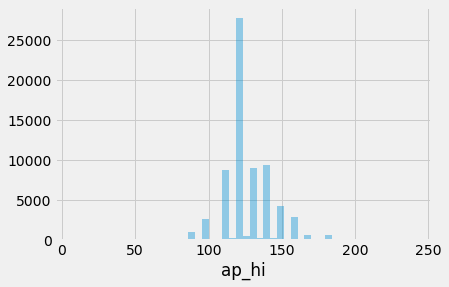

In [12]:
sns.distplot(data['ap_hi'],kde=False)

<AxesSubplot:xlabel='ap_lo'>

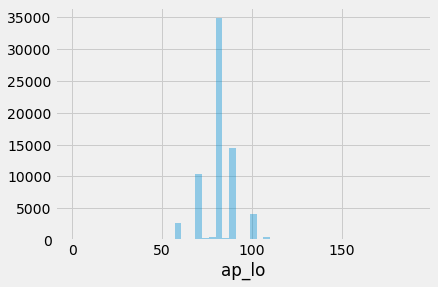

In [13]:
sns.distplot(data['ap_lo'],kde=False)

In [14]:
data.columns

Index(['index', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [15]:
data_target = data['cardio']
data.drop(labels=['cardio','index'], axis=1,inplace=True)

In [16]:
data.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active'],
      dtype='object')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, data_target, test_size=0.2, random_state=RANDOM_SEED)

### 5.Tunning Models and test for all 16 features

#### 5.1 Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score , accuracy_score ,  recall_score, roc_auc_score

In [19]:
random_forest = GridSearchCV(estimator=RandomForestClassifier(),
                             param_grid={'n_estimators': [100, 300]},
                             cv=5,
                             scoring = ['roc_auc','accuracy', 'precision'],
                             refit='roc_auc',
                             n_jobs=-1).fit(X_train, y_train)

In [20]:
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
print(acc_random_forest,random_forest.best_params_)

100.0 {'n_estimators': 300}


In [21]:
forest_reg = random_forest.best_estimator_
forest_reg.fit(X_train, y_train)
final_predictions_rf = forest_reg.predict(X_test)

In [22]:
acc_test_random_forest = accuracy_score(y_test, final_predictions_rf)
print("Acurácia é de {}%".format(round(acc_test_random_forest * 100, 2))) 


Acurácia é de 71.21%


In [23]:
prec_test_random_forest = precision_score(y_test, final_predictions_rf)
print("Precisão é de {}%".format(round(acc_test_random_forest * 100, 2))) 


Precisão é de 71.21%


In [24]:
recall_test_random_forest = recall_score(y_test, final_predictions_rf)
print("Recall é de {}%".format(round(recall_test_random_forest * 100, 2))) 


Recall é de 69.79%


#### 5.2 XGBoost Classifier

In [25]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from sklearn.metrics import roc_auc_score

In [26]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    current_score = cross_val_score(clf, X_train, y_train, cv=5,n_jobs=-1).mean()
    print(current_score, params)
    return current_score 
 
space_xgb = {
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.005),
            'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.005),
            'gamma': hp.quniform('gamma', 0.5, 1, 0.005),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'tree_method': 'exact',
            'silent': 1,
            'missing': None
        }
 
best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.7346798297255683                                                             
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.20500000000000002, 'eval_metric': 'auc', 'gamma': 0.64, 'learning_rate': 0.0058000000000000005, 'max_depth': 10, 'min_child_weight': 6.1000000000000005, 'missing': None, 'n_estimators': 127, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.72, 'tree_method': 'exact'}
0.7317996558282764                                                             
{'booster': 'gbtree', 'colsample_bytree': 0.685, 'eta': 0.07, 'eval_metric': 'auc', 'gamma': 0.9550000000000001, 'learning_rate': 0.0383, 'max_depth': 11, 'min_child_weight': 8.700000000000001, 'missing': None, 'n_estimators': 447, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.81, 'tree_method': 'exact'}
0.728865139027262                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.6, 'eta': 0.09, 'eval_metric': 'auc', 'gamma': 0.865, 'learni

In [27]:
params = space_eval(space_xgb, best)
params

{'booster': 'gbtree',
 'colsample_bytree': 0.6,
 'eta': 0.09,
 'eval_metric': 'auc',
 'gamma': 0.865,
 'learning_rate': 0.0451,
 'max_depth': 11,
 'min_child_weight': 6.0,
 'missing': None,
 'n_estimators': 861,
 'objective': 'binary:logistic',
 'silent': 1,
 'subsample': 0.975,
 'tree_method': 'exact'}

In [28]:
XGB_Classifier = XGBClassifier(**params)
XGB_Classifier.fit(X_train, y_train)
final_predictions_xgb = XGB_Classifier.predict(X_test)

[19:12:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




#### 5.2.1 XGB - Scores

In [29]:
acc_test_XGB_Classifier = accuracy_score(y_test, final_predictions_xgb)
print("Acurácia é de {}%".format(round(acc_test_XGB_Classifier * 100, 2))) 


Acurácia é de 73.03%


In [30]:
prec_test_XGB_Classifier = precision_score(y_test, final_predictions_xgb)
print("Precisão é de {}%".format(round(prec_test_XGB_Classifier * 100, 2))) 

Precisão é de 74.96%


In [31]:
recall_test_XGB_Classifier = recall_score(y_test, final_predictions_xgb)
print("Recall é de {}%".format(round(recall_test_XGB_Classifier * 100, 2))) 

Recall é de 69.05%


### 6.0 Performance dos Modelos

In [32]:
models = pd.DataFrame({
    'Model':['Random Forest','XGBoost Classifier'],
    'Score_accuracy': [acc_test_random_forest,acc_test_XGB_Classifier],
    'Score_precision':[prec_test_random_forest,prec_test_XGB_Classifier],
    'Score_recall':[recall_test_random_forest,recall_test_XGB_Classifier]
    
})

In [33]:
models.sort_values(by=['Score_accuracy', 'Score_precision'], ascending=False)

,Model,Score_accuracy,Score_precision,Score_recall
1,XGBoost Classifier,0.730256,0.749567,0.690511
0,Random Forest,0.712071,0.717696,0.697911


In [34]:
models.sort_values(by=['Score_recall'], ascending=False)

,Model,Score_accuracy,Score_precision,Score_recall
0,Random Forest,0.712071,0.717696,0.697911
1,XGBoost Classifier,0.730256,0.749567,0.690511


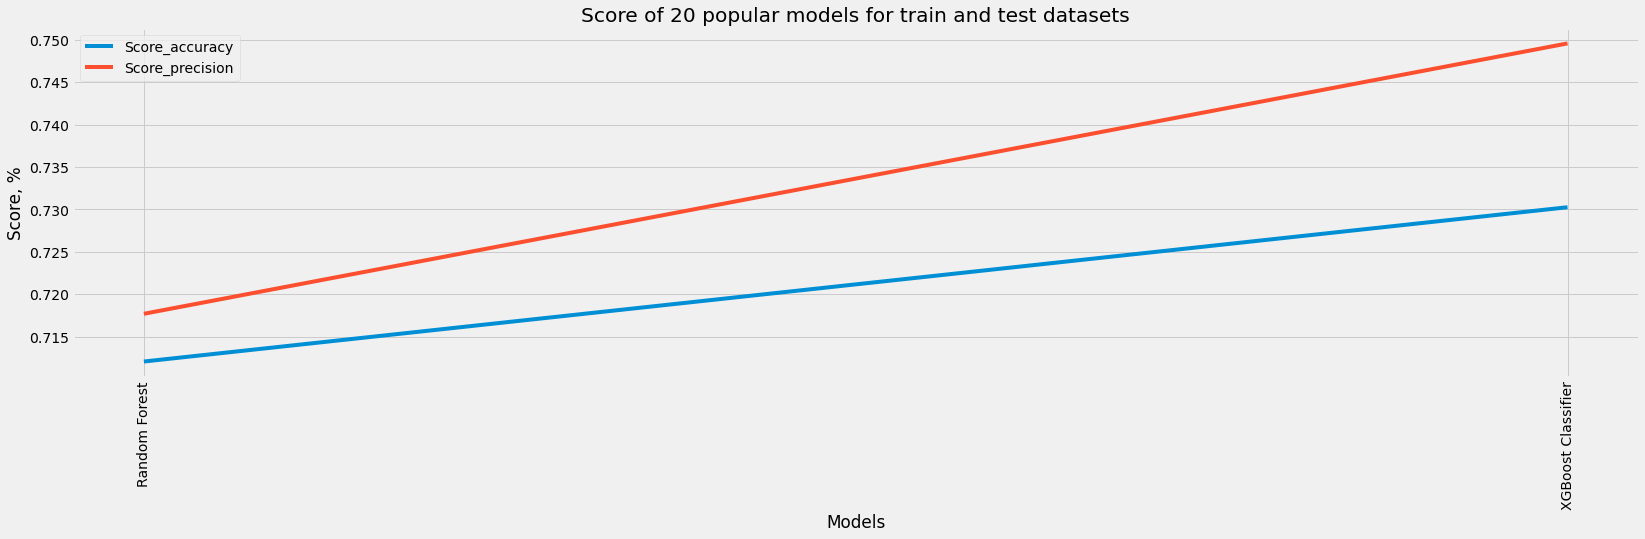

In [35]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['Score_accuracy'], label = 'Score_accuracy')
plt.plot(xx, models['Score_precision'], label = 'Score_precision')
plt.legend()
plt.title('Score of 20 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('Score, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

In [36]:
def calculo_performance_negocio(precision):
    precision = int(precision/5)-10
    valor = precision * 500
    lucro = valor - 1000
    return lucro

In [37]:
models['Performance_Negocio'] = models['Score_precision'].apply(lambda x: calculo_performance_negocio(x))

In [38]:
models

,Model,Score_accuracy,Score_precision,Score_recall,Performance_Negocio
0,Random Forest,0.712071,0.717696,0.697911,-6000
1,XGBoost Classifier,0.730256,0.749567,0.690511,-6000


### 7.0 Interpretação do Modelo

#### Médias da Features(Variáveis)

In [61]:
pd.DataFrame(data.mean())

,0
age,53.325446
gender,1.348733
height,164.359601
weight,74.117778
ap_hi,126.320315
ap_lo,81.333531
cholesterol,1.364369
gluc,1.225832
smoke,0.087861
alco,0.053589


#### Método Convencional - Feature Importance

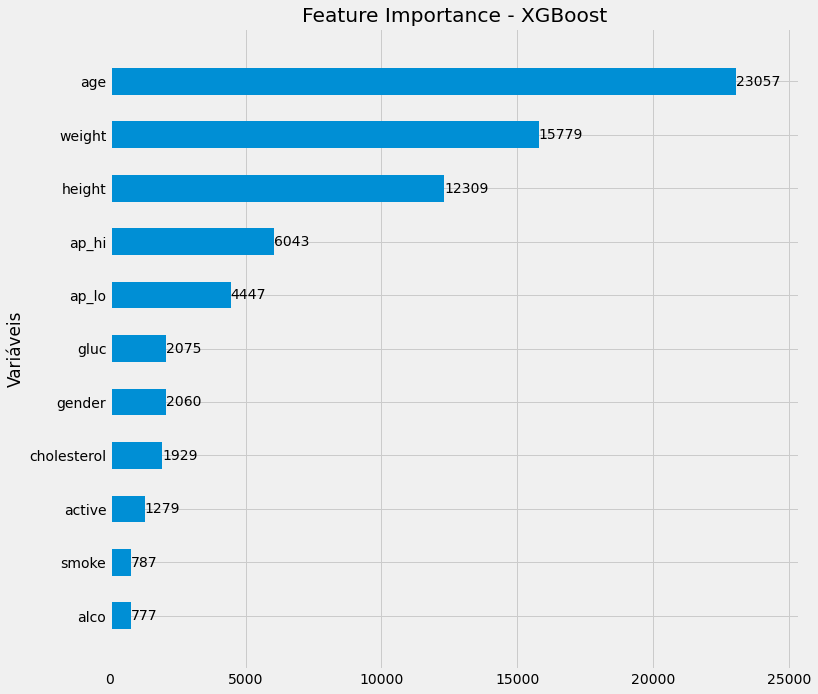

In [39]:
fig =  plt.figure(figsize = (11,11))
axes = fig.add_subplot(111)
xgb.plot_importance(XGB_Classifier,ax = axes,height =0.5)
plt.title("Feature Importance - XGBoost")
plt.xlabel('')
plt.ylabel('Variáveis')
plt.show();
plt.close()

In [40]:
import shap

In [41]:
def ABS_SHAP(shap_values,df,feat_lim_n):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(shap_values)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    k2 = k2.tail(feat_lim_n)
    #print(k2)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Vermelho = Impacto Positvo)")
    ax.set_ylabel("Variáveis")
    for index, value in enumerate(k2['SHAP_abs']):
        plt.text(value, index, str(np.around(value,4)))
    plt.show()
    
def shap_plot(i,model):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # visualize the first prediction's explanation
    shap.force_plot(explainer.expected_value, shap_values[i,:], X_test.iloc[i,:])

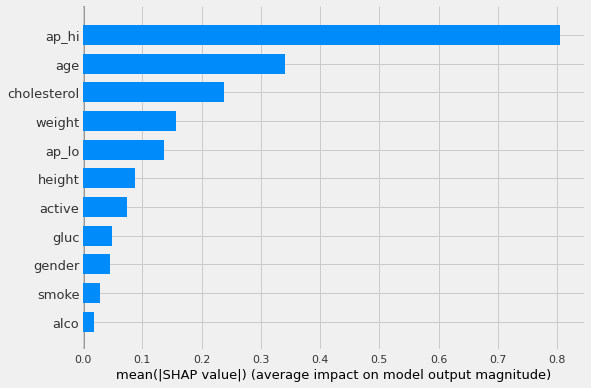

In [42]:
xgb_shap_values = shap.TreeExplainer(XGB_Classifier).shap_values(X_test)
shap.summary_plot(xgb_shap_values, X_test, plot_type="bar")

In [43]:
X_test.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active'],
      dtype='object')

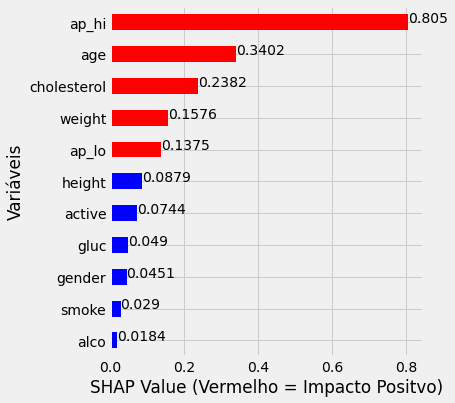

In [44]:
ABS_SHAP(xgb_shap_values,X_test,11)

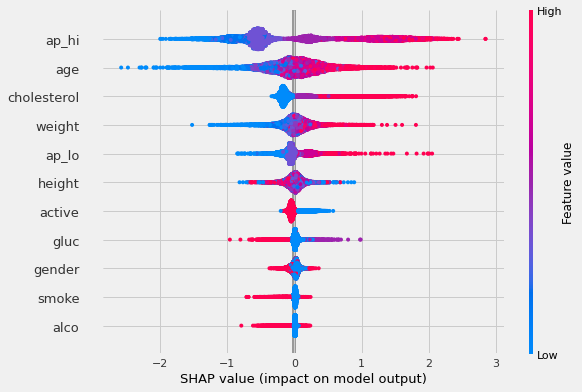

In [45]:
shap.summary_plot(xgb_shap_values, X_test)

In [50]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

In [51]:
explainer = shap.TreeExplainer(XGB_Classifier)
shap_values = explainer.shap_values(X_test)

In [58]:
i = 8
shap.plots.force(explainer.expected_value, shap_values[i,:], X_test.iloc[i,:])